In [ ]:
import umap
import json
import joblib
import pandas as pd
import numpy as np
import cupy as cp
from google.colab import drive
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml import UMAP, KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sentence_transformers import SentenceTransformer
from collections import defaultdict


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# SVD+UMAP K-Means DBSCAN

Clustering

[2025-07-31 22:16:56.660] [CUML] [info] build_algo set to brute_force_knn because random_state is given
Saved 2D projection for visualization.

==== Results for k=5 ====
Silhouette Score:        0.9668
Calinski-Harabasz Index: 4667.7
Davies-Bouldin Index:    0.8686
KMeans cluster sizes:    [281163     11      1     47      1]
[2025-07-31 22:33:56.621] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8981 -> 7637. Using the larger integer type might result in better performance
DBSCAN detected noise points: 4869

==== Results for k=10 ====
Silhouette Score:        0.9383
Calinski-Harabasz Index: 5580.5
Davies-Bouldin Index:    1.3956
KMeans cluster sizes:    [   342 280371      1      1      1     43     10      1    226    227]
[2025-07-31 22:49:56.182] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9007 -> 7659. Using the larger integer type might result in better performance
DBSCAN detected noise points: 4868

==== Results for k=20 ====
S

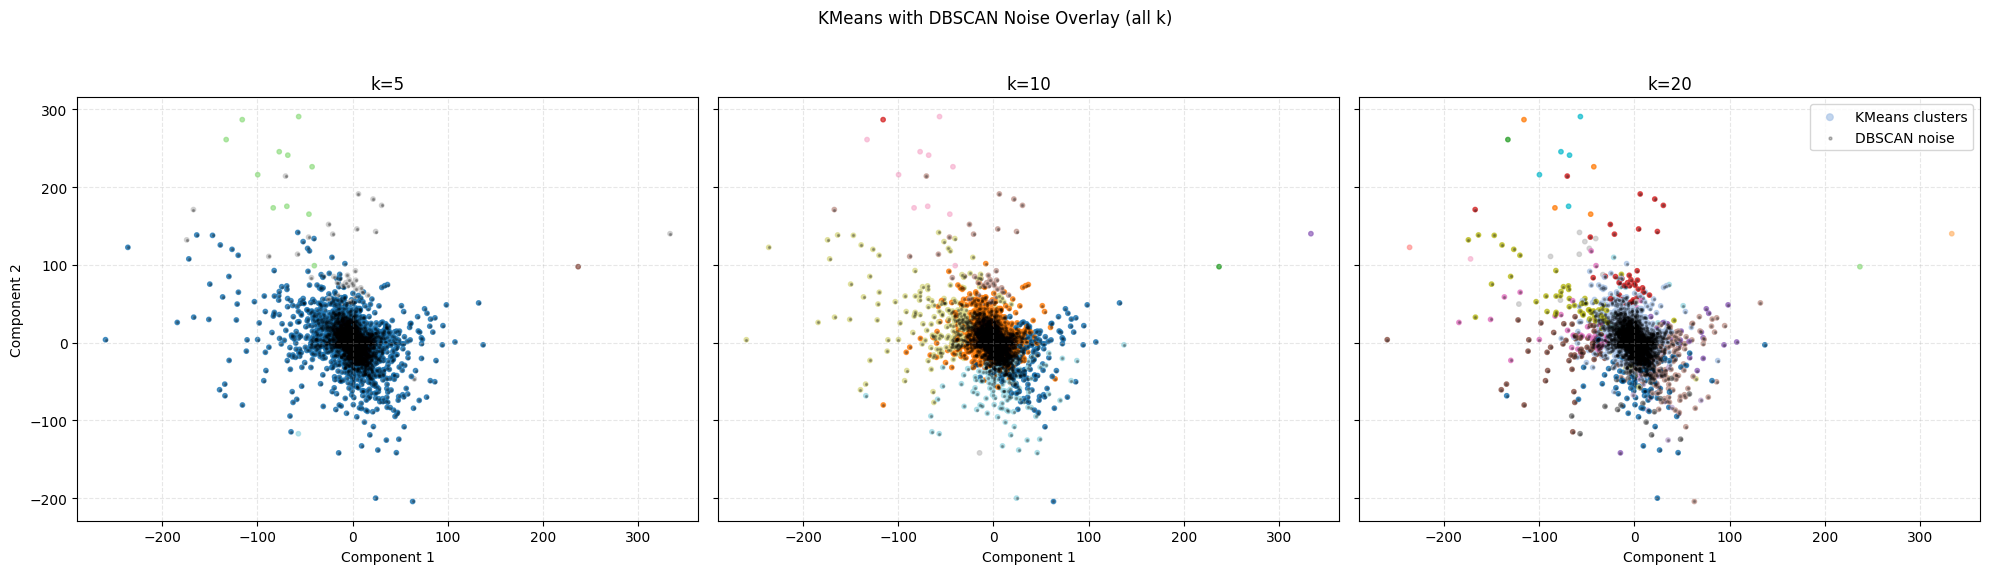


All done.


In [ ]:
# PARAMETERS
TFIDF_PATH = "/content/drive/MyDrive/MSE 641 Project Data/tfidf_matrix_fast.pkl"
UMAP_DIM = 30
UMAP_N_NEIGHBORS = 30
SVD_COMPONENTS = 200
K_RANGE = [5, 10, 20]
DBSCAN_EPS = 1.2
DBSCAN_MIN_SAMPLES = 15
OUTPUT_DIR = "/content/drive/MyDrive/MSE 641 Project Data/"

# LOAD & PREPROCESS
X = joblib.load(TFIDF_PATH)
svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=42)
X_svd = svd.fit_transform(X)
norms = np.linalg.norm(X_svd, axis=1)
X_svd = X_svd[norms > 0]
X_svd, _ = np.unique(X_svd, axis=0, return_index=True)

# UMAP REDUCTION
X_gpu = cp.asarray(X_svd)
umap = UMAP(
  n_components=UMAP_DIM,
  random_state=42,
  n_neighbors=UMAP_N_NEIGHBORS,
  min_dist=0.1
)
X_umap = cp.asnumpy(umap.fit_transform(X_gpu))

# PROJECT TO 2D FOR PLOTTING
if UMAP_DIM > 2:
    proj2d = TruncatedSVD(n_components=2, random_state=42)
    X_2d = proj2d.fit_transform(X_umap)
else:
    X_2d = X_umap

# Save the 2D projection for later visualization use
joblib.dump(X_2d, OUTPUT_DIR + "umap_2d.pkl")
print("Saved 2D projection for visualization.")

# Subplot for all k
fig, axes = plt.subplots(1, len(K_RANGE), figsize=(20, 6), sharex=True, sharey=True)
if len(K_RANGE) == 1:
    axes = [axes]

for i, K in enumerate(K_RANGE):
  # KMeans clustering
  kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
  k_labels = kmeans.fit_predict(X_umap)

  # Save KMeans labels
  joblib.dump(k_labels, OUTPUT_DIR + f"kmeans_labels_k{K}.pkl")

  # Cluster evaluation metrics
  if len(np.unique(k_labels)) > 1:
    sil = silhouette_score(X_umap, k_labels)
    ch = calinski_harabasz_score(X_umap, k_labels)
    db = davies_bouldin_score(X_umap, k_labels)
  else:
    sil, ch, db = np.nan, np.nan, np.nan

  print(f"\n==== Results for k={K} ====")
  print(f"Silhouette Score:        {sil:.4f}")
  print(f"Calinski-Harabasz Index: {ch:.1f}")
  print(f"Davies-Bouldin Index:    {db:.4f}")
  print(f"KMeans cluster sizes:    {np.bincount(k_labels)}")

  # DBSCAN inside each KMeans cluster to find noise
  noise_indices = []
  for cluster_id in np.unique(k_labels):
    mask = (k_labels == cluster_id)
    X_cluster = X_umap[mask]
    idx_cluster = np.where(mask)[0]
    if len(X_cluster) < DBSCAN_MIN_SAMPLES:
        continue
    dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
    db_labels = dbscan.fit_predict(X_cluster)
    noise_in_cluster = idx_cluster[db_labels == -1]
    noise_indices.extend(noise_in_cluster.tolist())

  print(f"DBSCAN detected noise points: {len(noise_indices)}")

  # Save DBSCAN noise indices
  joblib.dump(noise_indices, OUTPUT_DIR + f"dbscan_noise_indices_k{K}.pkl")

  # PLOT overlay
  ax = axes[i]
  # main clustering group
  sc = ax.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=k_labels, cmap="tab20",
    s=10, alpha=0.75,
    label="KMeans clusters"
  )
  # noise points
  if noise_indices:
    ax.scatter(
      X_2d[noise_indices, 0],
      X_2d[noise_indices, 1],
      c="k", marker=".", s=8,
      label="DBSCAN noise", alpha=0.25
      )
  ax.set_title(f"k={K}")
  ax.set_xlabel("Component 1")
  if i == 0:
    ax.set_ylabel("Component 2")
  ax.grid(True, linestyle="--", alpha=0.3)
  if i == len(K_RANGE) - 1:
    ax.legend(markerscale=1.5)

plt.suptitle("KMeans with DBSCAN Noise Overlay (all k)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Optionally, save the combined plot
plt.savefig(OUTPUT_DIR + "kmeans_dbscan_subplots.png", dpi=180)
plt.show()

print("\nAll done.")


Clustering result example

In [ ]:
TOP_N = 10
K_RANGE = [5, 10, 20]

for K_VAL in K_RANGE:
    print(f"\n===== Top {TOP_N} Examples per Cluster for k = {K_VAL} =====\n")
    # Load cluster labels and noise indices for this k
    k_labels = joblib.load(OUTPUT_DIR + f"kmeans_labels_k{K_VAL}.pkl")
    dbscan_noise_indices = joblib.load(OUTPUT_DIR + f"dbscan_noise_indices_k{K_VAL}.pkl")
    df['cluster'] = k_labels
    df['dbscan_noise'] = False
    df.loc[dbscan_noise_indices, 'dbscan_noise'] = True

    for cluster_id, group in df[df['dbscan_noise'] == False].groupby('cluster'):
        count = len(group)
        print(f"\n--- Cluster {cluster_id} ({count} samples) ---")
        for idx, row in enumerate(group.head(TOP_N).itertuples(), 1):
            prompt = row.prompt
            response = row.response
            short_prompt = (prompt[:100] + "...") if len(prompt) > 100 else prompt
            short_response = (response[:100] + "...") if len(response) > 100 else response
            print(f"{idx}. Prompt: {short_prompt}")
            print(f"   Response: {short_response}\n")



===== Top 10 Examples per Cluster for k = 5 =====


--- Cluster 0 (276341 samples) ---
1. Prompt: please refactor this php code countrycode shippingaddressgetcountrygetcode countrycode countrycode e...
   Response: countrycode  shippingaddressgetcountrygetcode
if countrycode  en 
    countrycode  uk

2. Prompt: rsyncfile have vanish
   Response: rsyncfile has vanishedrsyncfile has vanished



1 

2 rsyncignoreerrors

3 delete

4 inplacersync

5...

3. Prompt: imagebutton androidididimagebuttonprofile androidlayoutgravitycenterhorizontal androidbackgrounddraw...
   Response: androidbackgrounddrawablecirclebackground 
androidcliptooutlinetrue 
androidoutlineproviderbackgroun...

4. Prompt: button androidididbuttonregister androidtextregister androidlayoutwidthmatchparent androidlayoutheig...
   Response: button
    androidididbuttonregister
    androidtextregister
    androidlayoutwidthmatchparent
    a...

5. Prompt: cnc machinessuppli compliancesourcing surplus
   Response: 1 cnc mach

# BERT all

Clustering and visualization

Batches:   0%|          | 0/4441 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[2025-08-01 02:04:58.777] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 22165 -> 18818. Using the larger integer type might result in better performance
[2025-08-01 02:06:52.195] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 43663 -> 37049. Using the larger integer type might result in better performance
[2025-08-01 02:07:51.949] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 44360 -> 37640. Using the larger integer type might result in better performance
[2025-08-01 02:22:14.031] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 49877 -> 42318. Using the larger integer type might result in better performance
[2025-08-01 02:22:42.801] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 21435 -> 18198. Using the larger integer type might result in better performance
[2025-08-01 02:24:53.661] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 42529 -> 3608

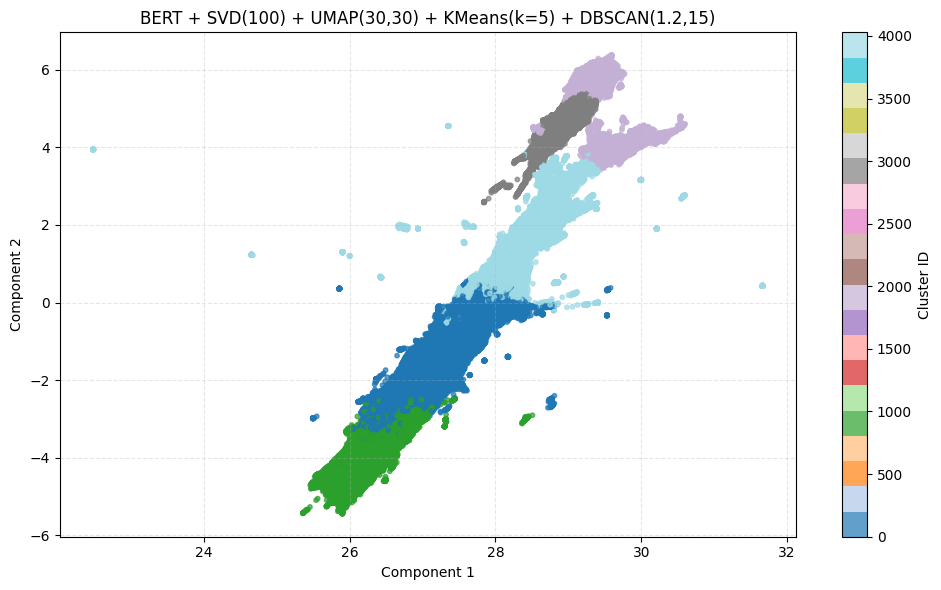

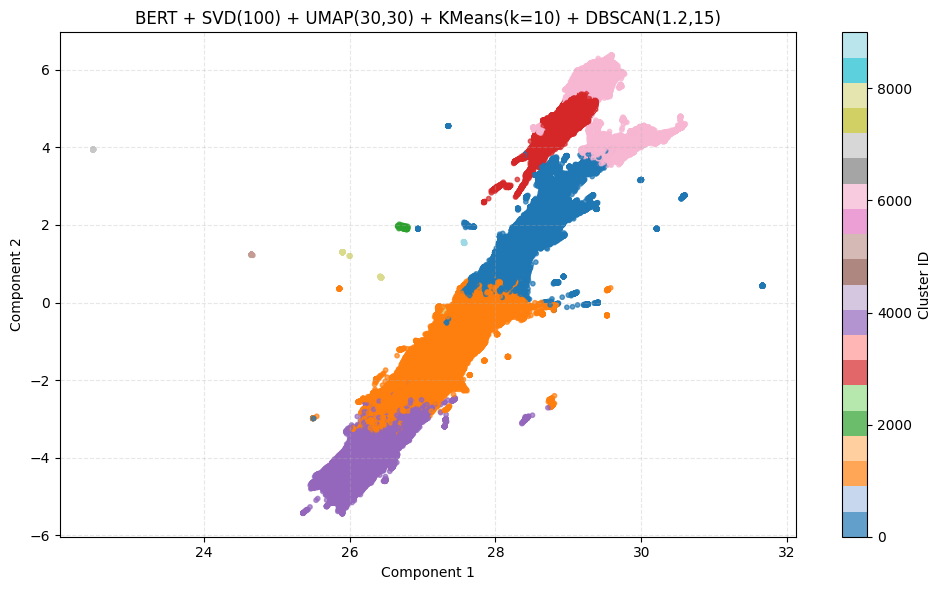

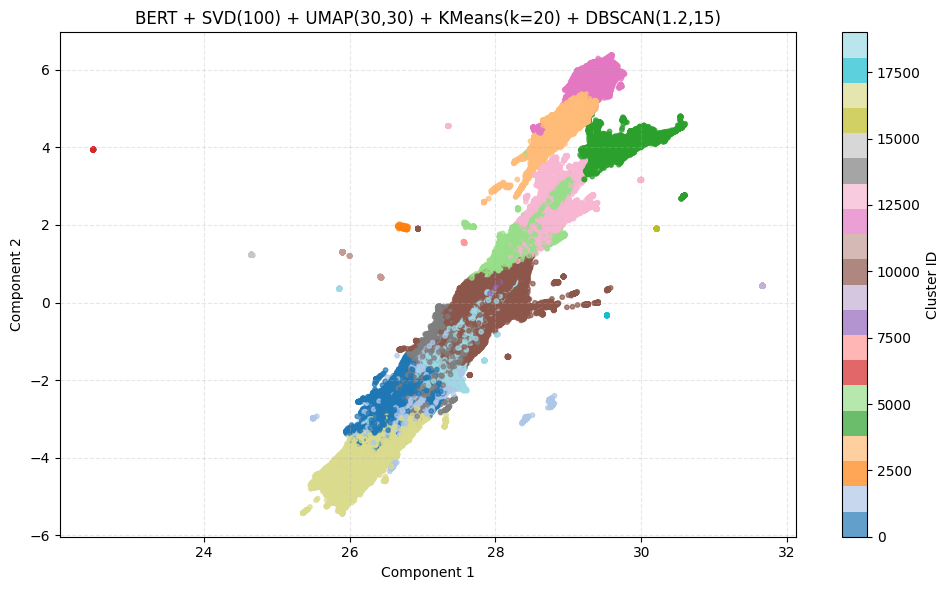

In [ ]:
# load data
in_path = "/content/drive/MyDrive/MSE 641 Project Data/wildchat_en_cleaned.jsonl"
prompts = []
responses = []

with open(in_path, "r", encoding="utf-8") as f:
  for line in f:
    obj = json.loads(line)
    if "prompt" in obj and "response" in obj:
      prompts.append(obj["prompt"])
      responses.append(obj["response"])
texts = [p + " " + r for p, r in zip(prompts, responses)]

# BERT embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

# SVD first to 100
SVD_DIM = 100
svd = TruncatedSVD(n_components=SVD_DIM, random_state=42)
X_svd = svd.fit_transform(embeddings)

# UMAP to 30
umap_neighbors = [30]
umap_dims = [30]
k_range = [5, 10, 20]
dbscan_eps = 1.2
dbscan_min_samples = 15

results = []
best_k_results = {}

for umap_dim in umap_dims:
  for umap_nn in umap_neighbors:
    umap_model = umap.UMAP(n_components=umap_dim, n_neighbors=umap_nn, random_state=42)
    X_umap = umap_model.fit_transform(X_svd)

    for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans_labels = kmeans.fit_predict(X_umap)

      final_labels = np.full(len(X_umap), -1)
      for i in range(k):
        idx = (kmeans_labels == i)
        if np.sum(idx) == 0:
            continue
        subcluster = X_umap[idx]
        dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        sub_labels = dbscan.fit_predict(subcluster)
        for j, sub_label in enumerate(sub_labels):
            global_idx = np.where(idx)[0][j]
            if sub_label >= 0:
                final_labels[global_idx] = i * 1000 + sub_label
            else:
                final_labels[global_idx] = -1

      valid = final_labels >= 0
      X_valid = X_umap[valid]
      labels_valid = final_labels[valid]
      if len(np.unique(labels_valid)) > 1:
        sil = silhouette_score(X_valid, labels_valid)
        ch = calinski_harabasz_score(X_valid, labels_valid)
        db = davies_bouldin_score(X_valid, labels_valid)
      else:
        sil, ch, db = float('nan'), float('nan'), float('nan')

      results.append({
        'umap_dim': umap_dim,
        'umap_nn': umap_nn,
        'k': k,
        'dbscan_eps': dbscan_eps,
        'dbscan_min_samples': dbscan_min_samples,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'n_clusters': len(np.unique(labels_valid)),
      })

      if k not in best_k_results or sil > best_k_results[k]["silhouette"]:
        best_k_results[k] = {
          "silhouette": sil,
          "dim": umap_dim,
          "nn": umap_nn,
          "k": k,
          "labels": final_labels,
          "X_umap": X_umap
          }

# Save and Plot for Best Per-k Results
for k, result in best_k_results.items():
  X_umap = result["X_umap"]
  labels = result["labels"]
  dim = result["dim"]
  nn = result["nn"]

  joblib.dump(X_umap, f"/content/drive/MyDrive/MSE 641 Project Data/bert_umap_matrix_k{k}_best.pkl")
  joblib.dump(labels, f"/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_labels_k{k}_best.pkl")

  # visualization
  if X_umap.shape[1] > 2:
    svd2d = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd2d.fit_transform(X_umap)
  else:
    X_2d = X_umap

  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
  plt.title(f"BERT + SVD({SVD_DIM}) + UMAP({dim},{nn}) + KMeans(k={k}) + DBSCAN(1.2,15)")
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.grid(True, linestyle='--', alpha=0.3)
  plt.colorbar(scatter, label="Cluster ID")
  plt.tight_layout()
  plt.show()
  plt.savefig(f"/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_best_k{k}_plot.png")
  plt.close()

# Save evaluation summary
summary_df = pd.DataFrame(results)
summary_path = "/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_dbscan_metrics_best_per_k.csv"
summary_df.to_csv(summary_path, index=False)


Clustering metrics

In [ ]:
# Compute & display metrics from previously saved files
import os, re, glob
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

OUT_DIR = "/content/drive/MyDrive/MSE 641 Project Data"

label_files = sorted(glob.glob(os.path.join(OUT_DIR, "bert_kmeans_labels_k*_best.pkl")))
if not label_files:
  raise FileNotFoundError(f"No saved label files like 'bert_kmeans_labels_k*_best.pkl' found in {OUT_DIR}")

rows = []
for lf in label_files:
  fname = os.path.basename(lf)
  m = re.search(r"k(\d+)", fname)
  if not m:
    print(f"[skip] cannot parse k from: {fname}")
    continue
  k = int(m.group(1))

  umap_path = os.path.join(OUT_DIR, f"bert_umap_matrix_k{k}_best.pkl")
  if not os.path.exists(umap_path):
    print(f"[skip] UMAP matrix for k={k} not found: {umap_path}")
    continue

  # load data
  X_umap = joblib.load(umap_path)
  labels = joblib.load(lf)

  # calculate evaluation metrics
  mask = labels >= 0
  X_valid = X_umap[mask]
  labels_valid = labels[mask]
  if X_valid.shape[0] > 0 and np.unique(labels_valid).size > 1:
    sil = silhouette_score(X_valid, labels_valid)
    ch = calinski_harabasz_score(X_valid, labels_valid)
    db = davies_bouldin_score(X_valid, labels_valid)
  else:
    sil = ch = db = np.nan

  print(f"\n==== Metrics for k={k} (valid points: {mask.sum()}/{len(labels)}) ====")
  print(f"Silhouette Score:        {sil:.4f}" if np.isfinite(sil) else "Silhouette Score:        NaN")
  print(f"Calinski-Harabasz Index: {ch:.1f}"  if np.isfinite(ch)  else "Calinski-Harabasz Index: NaN")
  print(f"Davies-Bouldin Index:    {db:.4f}" if np.isfinite(db) else "Davies-Bouldin Index:    NaN")

  rows.append({
    "k": k,
    "silhouette": sil,
    "calinski_harabasz": ch,
    "davies_bouldin": db,
    "valid_n": int(mask.sum())
  })

# display
if rows:
  df = pd.DataFrame(rows).sort_values("k")
  print("\nSummary:")
  print(df.to_string(index=False))



==== Metrics for k=10 (valid points: 284146/284168) ====
Silhouette Score:        0.2833
Calinski-Harabasz Index: 33341.9
Davies-Bouldin Index:    0.3937

==== Metrics for k=20 (valid points: 284141/284168) ====
Silhouette Score:        0.3701
Calinski-Harabasz Index: 63375.7
Davies-Bouldin Index:    0.4442

==== Metrics for k=5 (valid points: 284151/284168) ====
Silhouette Score:        0.2855
Calinski-Harabasz Index: 34588.7
Davies-Bouldin Index:    0.4017

Summary:
 k  silhouette  calinski_harabasz  davies_bouldin  valid_n
 5    0.285474       34588.699219        0.401710   284151
10    0.283329       33341.949219        0.393665   284146
20    0.370053       63375.660156        0.444172   284141


clustering result example

In [ ]:
# BERT clustering result

import pandas as pd

df_clu = pd.DataFrame({
  'prompt': prompts,
  'response': responses,
  'cluster': labels
})

TOP_N = 10

for clu_id, group in df_clu[df_clu['cluster'] != -1].groupby('cluster'):
  print(f"\n--- Cluster {clu_id} ({len(group)} samples) ---")
  for idx, row in enumerate(group.head(TOP_N).itertuples(), 1):
    short_prompt = (row.prompt[:100] + "...") if len(row.prompt) > 100 else row.prompt
    short_response = (row.response[:100] + "...") if len(row.response) > 100 else row.response
    print(f"{idx}. Prompt: {short_prompt}")
    print(f"   Response: {short_response}\n")

# noise points
noise = df_clu[df_clu['cluster'] == -1]
if not noise.empty:
  print(f"\n--- Noise (DBSCAN label=-1), {len(noise)} samples ---")
  for idx, row in enumerate(noise.head(TOP_N).itertuples(), 1):
    short_prompt = (row.prompt[:100] + "...") if len(row.prompt) > 100 else row.prompt
    short_response = (row.response[:100] + "...") if len(row.response) > 100 else row.response
    print(f"{idx}. Prompt: {short_prompt}")
    print(f"   Response: {short_response}\n")



--- Cluster 0 (33607 samples) ---
1. Prompt: hi there could you please review an email for I thank you for your email its great to know that you ...
   Response: sure id be happy to help please share the email and any specific areas you would like me to review

...

2. Prompt: I want you to act as enterpreneur and marketing expert you have own a product name hexagonal pull up...
   Response: ok i understand that i am an entrepreneur and marketing expert who owns a hexagonal pullup bar that ...

3. Prompt: I want you to act as enterpreneur and marketing expert you have own a product name as pull up bar su...
   Response: ok i understand that you would like me to pretend to be an entrepreneur and marketing expert for a p...

4. Prompt: the price of gold and from give I a chart
   Response: to 2021

unfortunately as an ai language model i am unable to browse the internet for current inform...

5. Prompt: who be you I want you to act as enterpreneur and marketing expert you own a product 

Mapping

In [ ]:
# O*NET mapping + save + stats

import os, re, json, glob, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import groupby
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import joblib

warnings.filterwarnings("ignore", category=FutureWarning)

# Path
DATA_DIR = "/content/drive/MyDrive/MSE 641 Project Data"
ONET_CSV = os.path.join(DATA_DIR, "Task_Statements_standardized.csv")
JSONL_CHAT = os.path.join(DATA_DIR, "wildchat_en_cleaned.jsonl")
METRICS_CSV = os.path.join(DATA_DIR, "bert_kmeans_dbscan_metrics_best_per_k.csv")
LABEL_GLOB = os.path.join(DATA_DIR, "bert_kmeans_labels_k*_best.pkl")
OUT_CSV = os.path.join(DATA_DIR, "onet_mapping_results.csv")
OUT_JSONL = os.path.join(DATA_DIR, "onet_mapping_results.jsonl")

TOP_K_CANDIDATES = 5  # how many O*NET candidates to show to LLM
REP_TOP_N = 5  # how many representative samples per cluster (by center similarity)

# OpenAI client or fallback
openai_api_key = os.environ.get("OPENAI_API_KEY", "")
USE_LLM = False
try:
  if not openai_api_key:
    # Try Colab Secrets if available
    from google.colab import userdata  # type: ignore
    openai_api_key = userdata.get("OPENAI_API_KEY") or ""
    if openai_api_key:
      os.environ["OPENAI_API_KEY"] = openai_api_key
except Exception:
  pass

if openai_api_key:
  try:
    from openai import OpenAI
    client = OpenAI(api_key=openai_api_key)
    LLM_MODEL = "gpt-4o-mini-2024-07-18"
    USE_LLM = True
    print("[INFO] OPENAI_API_KEY detected. LLM selection enabled.")
  except Exception as e:
    print(f"[WARN] Failed to init OpenAI client: {e}")
    print("[WARN] Proceeding WITHOUT LLM (top-1 cosine fallback).")
else:
  print("[WARN] OPENAI_API_KEY not set. Proceeding WITHOUT LLM (top-1 cosine fallback).")

# Load O*NET and embed
if not os.path.exists(ONET_CSV):
    raise FileNotFoundError(f"O*NET CSV not found: {ONET_CSV}")

onet_df = pd.read_csv(ONET_CSV)
onet_codes = onet_df["O*NET-SOC Code"].astype(str).tolist()
onet_titles = onet_df["Title"].astype(str).tolist()
onet_descs = onet_df["Task"].astype(str).tolist()
onet_texts = onet_df["task_standardized"].astype(str).tolist()

print(f"[INFO] Loaded O*NET rows: {len(onet_texts)}")

embed_model = SentenceTransformer("all-MiniLM-L6-v2")
onet_embs = embed_model.encode(onet_texts, batch_size=64, show_progress_bar=True)

# Load clustered conversations (prompt+response)
texts = []
with open(JSONL_CHAT, "r", encoding="utf-8") as f:
  for line in f:
    if not line.strip():
      continue
    obj = json.loads(line)
    if "prompt" in obj and "response" in obj:
      p = str(obj["prompt"]).strip()
      r = str(obj["response"]).strip()
      texts.append((p + " " + r).strip())
print(f"[INFO] Loaded conversations: {len(texts)}")

# Determine k values to process
if os.path.exists(METRICS_CSV):
  summary_df = pd.read_csv(METRICS_CSV)
  best_ks = sorted(pd.unique(summary_df["k"]))
else:
  label_files = glob.glob(LABEL_GLOB)
  best_ks = sorted({int(re.search(r"k(\d+)", os.path.basename(p)).group(1)) for p in label_files})
print("[INFO] k values found:", best_ks)

# Mapping
results = []

for k in tqdm(best_ks, desc="Mapping per k"):
  labels_path = os.path.join(DATA_DIR, f"bert_kmeans_labels_k{k}_best.pkl")
  if not os.path.exists(labels_path):
    print(f"[skip] labels not found for k={k}: {labels_path}")
    continue

  labels = joblib.load(labels_path)
  if len(labels) != len(texts):
    print(f"[skip] len(labels) != len(texts) for k={k}: {len(labels)} vs {len(texts)}")
    continue

  df = pd.DataFrame({"text": [t for t in texts], "label": labels})
  # deterministic order
  for cid, group in df.groupby("label", sort=True):
    all_texts = group["text"].tolist()

    # Representative samples: closest to cluster center in embedding space
    if not all_texts:
      samples = []
    else:
      text_embs = embed_model.encode(all_texts, batch_size=32, show_progress_bar=False)
      center    = text_embs.mean(axis=0).reshape(1, -1)
      sims      = cosine_similarity(center, text_embs)[0]
      n_pick    = min(REP_TOP_N, len(all_texts))
      top_idxs  = np.argsort(-sims)[:n_pick]
      samples   = [all_texts[i] for i in top_idxs]
      # Deduplicate samples but keep order
      samples   = [*dict.fromkeys(samples)]

    if not samples:
      results.append({
        "k": k, "Cluster": int(cid),
        "O*NET Code": None, "Title": None, "Description": None,
        "Similarity": None, "GPT Choice": "None", "Samples": samples
      })
      continue

    # Top-K O*NET by cosine similarity
    sample_vec = embed_model.encode(" ".join(samples), convert_to_numpy=True)
    scores     = cosine_similarity(sample_vec.reshape(1, -1), onet_embs)[0]
    cand_idxs  = np.argsort(-scores)[:TOP_K_CANDIDATES]

    if USE_LLM:
      # Build prompt for LLM disambiguation
      prompt  = "Cluster samples:\n"
      for i, s in enumerate(samples, 1):
        snippet = s.replace("\n", " ")[:200]
        prompt += f"{i}. {snippet}…\n"
      prompt += f"\nTop {TOP_K_CANDIDATES} O*NET candidates:\n"
      for i, idx in enumerate(cand_idxs, 1):
        prompt += (f"{i}. Code: {onet_codes[idx]}, Title: {onet_titles[idx]}\n"
              f"Desc: {onet_descs[idx][:200]}…\n")
      prompt += (f"\nWhich single candidate (1–{TOP_K_CANDIDATES}) best matches these samples? "
                  f"If none, reply 'None'. Just answer the number or None.")

      try:
        resp = client.chat.completions.create(
          model=LLM_MODEL,
          messages=[{"role": "user", "content": prompt}],
          temperature=0.0,
          max_tokens=10,
        )
        choice = (resp.choices[0].message.content or "").strip()
      except Exception as e:
        print(f"[warn] LLM error on k={k}, cluster={cid}: {e}")
        choice = "None"

      if choice.isdigit() and 1 <= int(choice) <= TOP_K_CANDIDATES:
        sel  = cand_idxs[int(choice) - 1]
        code, title, desc, sim = onet_codes[sel], onet_titles[sel], onet_descs[sel], float(scores[sel])
      else:
        code, title, desc, sim = None, None, None, None
  else:
    # No LLM: pick top-1 cosine candidate
    sel  = cand_idxs[0]
    code, title, desc, sim = onet_codes[sel], onet_titles[sel], onet_descs[sel], float(scores[sel])
    choice = "1* (no-LLM fallback)"

  results.append({
      "k": k,
      "Cluster": int(cid),
      "O*NET Code": code,
      "Title": title,
      "Description": desc,
      "Similarity": sim,
      "GPT Choice": choice,
      "Samples": samples
    })

# print per-k details
results_sorted = sorted(results, key=lambda x: (x["k"], x["Cluster"]))
for k_val, group in groupby(results_sorted, key=lambda x: x["k"]):
  print("\n" + "=" * 40)
  print(f"Results for k = {k_val}")
  print("=" * 40)
  for r in group:
    print(f"\nCluster {r['Cluster']} → {r['O*NET Code'] or 'None'}: {r.get('Title','') or 'No good match'}")
    print(f"Desc: {r.get('Description','') or ''}")
    print(f"Similarity: {r.get('Similarity','')}")
    print(f"GPT Picked: {r.get('GPT Choice','')}")
    print("Samples:")
    for i, s in enumerate(r.get("Samples", []), 1):
        snippet = s.replace("\n", " ")[:300]
        print(f"{i}. {snippet}…")

# saving (CSV + JSONL)
def _to_py_scalar(x):
  if isinstance(x, np.generic):
    return x.item()
  return x

def _sanitize_val(v):
  if isinstance(v, float) and (np.isnan(v) or np.isinf(v)):
    return None
  if isinstance(v, (np.floating, np.integer, np.bool_)):
    return v.item()
  if isinstance(v, list):
    return [_sanitize_val(x) for x in v]
  if isinstance(v, dict):
    return {k: _sanitize_val(x) for k, x in v.items()}
  return v

def _json_sanitized_records(df: pd.DataFrame):
  records = df.to_dict(orient="records")
  return [{k: _sanitize_val(v) for k, v in rec.items()} for rec in records]

# Normalize records & deduplicate by (k, Cluster)
rows  = [{k: _to_py_scalar(v) for k, v in r.items()} for r in results]
df_all = pd.DataFrame(rows)
dedup_keys = [c for c in ["k", "Cluster"] if c in df_all.columns]
if dedup_keys:
  df_all = df_all.drop_duplicates(subset=dedup_keys, keep="last").reset_index(drop=True)

# Clean records for JSONL/CSV
clean_records = _json_sanitized_records(df_all)

# Write JSONL
with open(OUT_JSONL, "w", encoding="utf-8") as f:
  for rec in clean_records:
    json.dump(rec, f, ensure_ascii=False, allow_nan=False)
    f.write("\n")

# Write CSV (stringify lists/dicts)
df_csv = pd.DataFrame(clean_records).copy()
for col in df_csv.columns:
  if df_csv[col].apply(lambda v: isinstance(v, (list, dict))).any():
    df_csv[col] = df_csv[col].apply(lambda v: json.dumps(v, ensure_ascii=False))
df_csv.to_csv(OUT_CSV, index=False)

print("\n[INFO] Saved:", OUT_CSV)
print("[INFO] Saved:", OUT_JSONL)

# Statistics
def _norm_code_series(s: pd.Series) -> pd.Series:
  s = s.astype(str).str.strip()
  return s.replace({"": np.nan, "None": np.nan, "none": np.nan, "nan": np.nan})

print("\n===== STATISTICS =====")
df_stats = pd.DataFrame(clean_records).copy()

# figure out code/title columns
code_col_candidates = ["O*NET Code", "O_NET_Code", "ONET Code", "ONET_Code", "Code"]
code_col = next((c for c in code_col_candidates if c in df_stats.columns), None)
if code_col is None:
  raise KeyError(f"Cannot find O*NET code column in: {df_stats.columns.tolist()}")
title_col = next((c for c in ["Title", "ONET Title", "O*NET Title"] if c in df_stats.columns), None)

df_stats[code_col] = _norm_code_series(df_stats[code_col])

total_rows = len(df_stats)
mapped_mask = df_stats[code_col].notna()
mapped_rows = int(mapped_mask.sum())
overall_rate = (mapped_rows / total_rows * 100) if total_rows else np.nan

print(f"Total clusters (rows): {total_rows}")
print(f"Mapped clusters:       {mapped_rows} ({overall_rate:.2f}%)")

mapped_df = df_stats.loc[mapped_mask].copy()
if title_col:
  mapped_df["Category"] = mapped_df[code_col].astype(str) + " — " + mapped_df[title_col].astype(str)
else:
  mapped_df["Category"] = mapped_df[code_col].astype(str)

counts = mapped_df["Category"].value_counts(dropna=False)
percentages = (counts / mapped_rows * 100).round(2) if mapped_rows else counts * np.nan
category_summary = pd.DataFrame({
  "Category": counts.index,
  "Count": counts.values,
  "Percentage_of_Mapped(%)": percentages.values
})

print("\nCategory distribution (among mapped clusters):")
print(category_summary.to_string(index=False))

if "k" in df_stats.columns:
  by_k = (
    df_stats.assign(mapped=mapped_mask.astype(int))
      .groupby("k")["mapped"]
      .agg(total="count", mapped="sum")
      .reset_index()
)
  by_k["mapping_rate_%"] = (by_k["mapped"] / by_k["total"] * 100).round(2)
  print("\nMapping rate by k:")
  print(by_k.to_string(index=False))
else:
  print("\nNo 'k' column found; skip per-k mapping rate.")

TOP_N = 10
print(f"\nTop {min(TOP_N, len(category_summary))} categories by count:")
print(category_summary.head(TOP_N).to_string(index=False))



[INFO] OPENAI_API_KEY detected. LLM selection enabled.
[INFO] Loaded O*NET rows: 18796


Batches:   0%|          | 0/294 [00:00<?, ?it/s]

[INFO] Loaded conversations: 284168
[INFO] k values found: [np.int64(5), np.int64(10), np.int64(20)]



Mapping per k: 100%|██████████| 3/3 [39:25<00:00, 788.43s/it]



Results for k = 5

Cluster -1 → None: No good match
Desc: 
Similarity: None
GPT Picked: None
Samples:
1. tiger wood and I will play hole of golf each of we be try hard to win tiger wood be play with his left hand tie behind his back who likely will get the good score think out loud considering tiger woods is a professional golfer and highly skilled even with his left hand tied behind his back he would …
2. tiger wood and I will play hole of golf each of we be try hard to win tiger wood be play with his left hand tie behind his back who likely will get the good score tiger woods will likely still get the best score even with his left hand tied behind his back he is a professional golfer with years of e…
3. I want you to act as my game advisorif the response in the question section be not a question no answeronly reply feel free to ask any gamerelated question if the question be word no answeronly reply please provide a more detailed description if the context provide insufficient infor

# BERT work only

Clustering and visualization

Batches:   0%|          | 0/1203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[2025-08-01 04:34:08.393] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 42024 -> 35658. Using the larger integer type might result in better performance
[2025-08-01 04:35:29.537] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 47040 -> 45652. Using the larger integer type might result in better performance


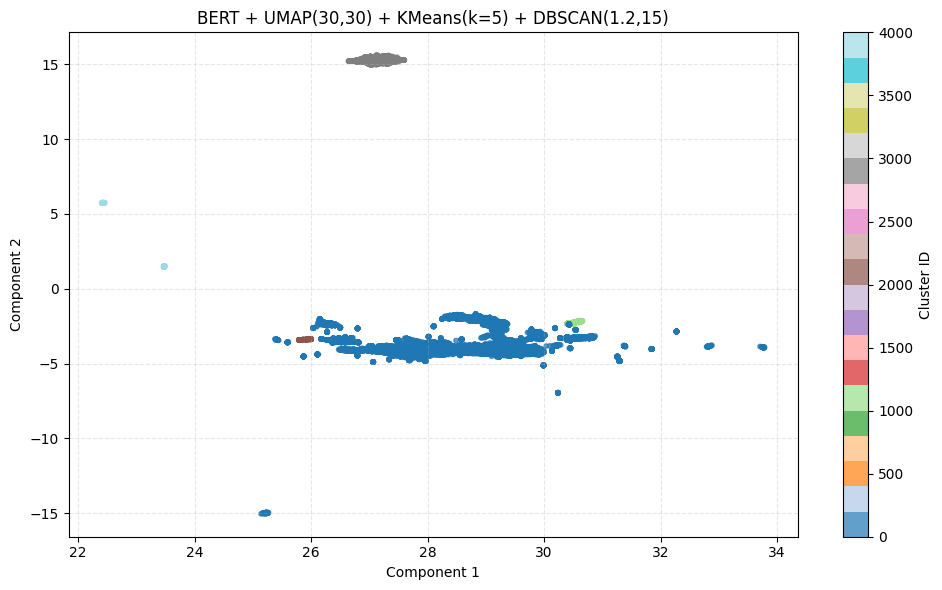

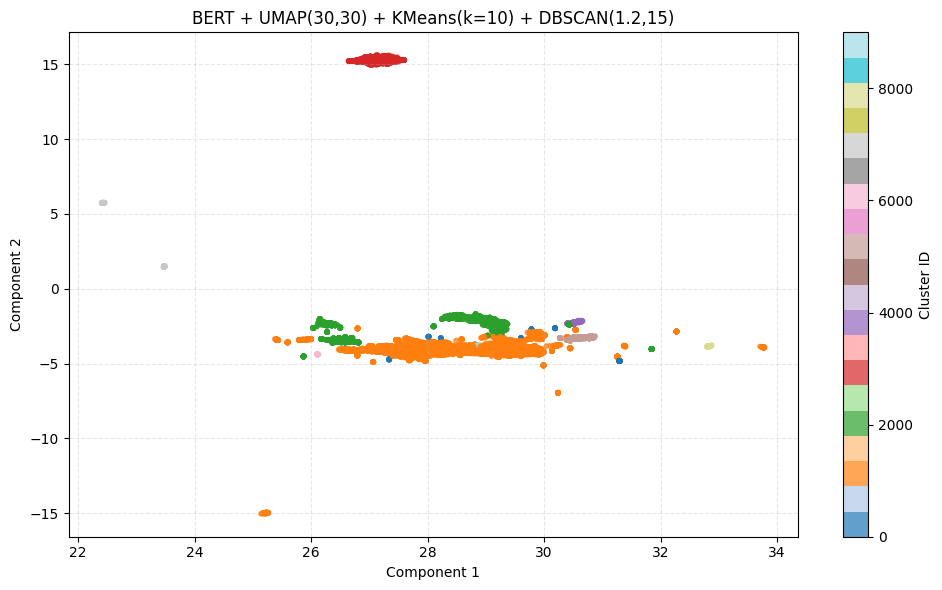

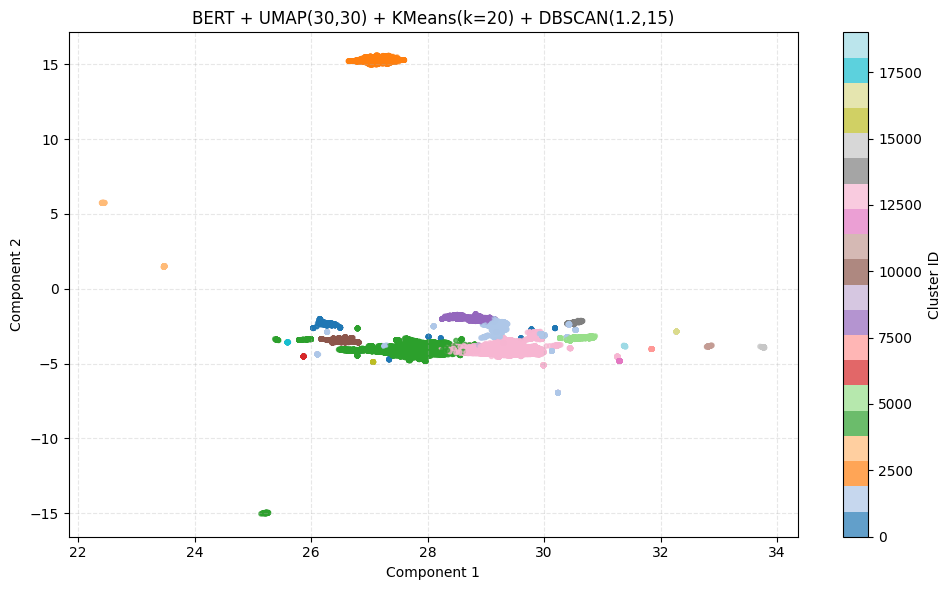

In [ ]:
# Load data
in_path = "/content/drive/MyDrive/MSE 641 Project Data/wildchat_work_only.jsonl"
texts = []

with open(in_path, "r", encoding="utf-8") as f:
  for line in f:
    obj = json.loads(line)
    if "conversation" in obj:
      conv = obj["conversation"]
      if "Prompt:" in conv and "Response:" in conv:
        prompt_part = conv.split("Prompt:")[1].split("Response:")[0].strip()
        response_part = conv.split("Response:")[1].strip()
        prompts.append(prompt_part)
        responses.append(response_part)
        texts.append(prompt_part + " " + response_part)

# BERT embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

SVD_DIM = 100
svd = TruncatedSVD(n_components=SVD_DIM, random_state=42)
X_svd = svd.fit_transform(embeddings)

# Parameters
umap_neighbors = [30]
umap_dims = [30]
k_range = [5, 10, 20]
dbscan_eps = 1.2
dbscan_min_samples = 15

results = []
best_k_results = {}

for umap_dim in umap_dims:
  for umap_nn in umap_neighbors:
    umap_model = umap.UMAP(n_components=umap_dim, n_neighbors=umap_nn, random_state=42)
    X_umap = umap_model.fit_transform(X_svd)

    for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans_labels = kmeans.fit_predict(X_umap)

      final_labels = np.full(len(X_umap), -1)
      for i in range(k):
        idx = (kmeans_labels == i)
        if np.sum(idx) == 0:
          continue
        subcluster = X_umap[idx]
        dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        sub_labels = dbscan.fit_predict(subcluster)
        for j, sub_label in enumerate(sub_labels):
          global_idx = np.where(idx)[0][j]
          if sub_label >= 0:
            final_labels[global_idx] = i * 1000 + sub_label
          else:
            final_labels[global_idx] = -1

      valid = final_labels >= 0
      X_valid = X_umap[valid]
      labels_valid = final_labels[valid]
      if len(np.unique(labels_valid)) > 1:
        sil = silhouette_score(X_valid, labels_valid)
        ch = calinski_harabasz_score(X_valid, labels_valid)
        db = davies_bouldin_score(X_valid, labels_valid)
      else:
        sil, ch, db = float('nan'), float('nan'), float('nan')

      results.append({
        'umap_dim': umap_dim,
        'umap_nn': umap_nn,
        'k': k,
        'dbscan_eps': dbscan_eps,
        'dbscan_min_samples': dbscan_min_samples,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'n_clusters': len(np.unique(labels_valid)),
      })

      if k not in best_k_results or sil > best_k_results[k]["silhouette"]:
        best_k_results[k] = {
          "silhouette": sil,
          "dim": umap_dim,
          "nn": umap_nn,
          "k": k,
          "labels": final_labels,
          "X_umap": X_umap
        }

# Save and Plot for Best Per-k Results
for k, result in best_k_results.items():
  X_umap = result["X_umap"]
  labels = result["labels"]
  dim = result["dim"]
  nn = result["nn"]

  joblib.dump(X_umap, f"/content/drive/MyDrive/MSE 641 Project Data/bert_umap_matrix_k{k}_best_work.pkl")
  joblib.dump(labels, f"/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_labels_k{k}_best_work.pkl")

  if X_umap.shape[1] > 2:
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X_umap)
  else:
    X_2d = X_umap

  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
  plt.title(f"BERT + UMAP({dim},{nn}) + KMeans(k={k}) + DBSCAN(1.2,15)")
  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.grid(True, linestyle='--', alpha=0.3)
  plt.colorbar(scatter, label="Cluster ID")
  plt.tight_layout()
  plt.show()
  plt.savefig(f"/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_best_k{k}_plot_work.png")
  plt.close()

# Save evaluation summary
summary_df = pd.DataFrame(results)
summary_path = "/content/drive/MyDrive/MSE 641 Project Data/bert_kmeans_dbscan_metrics_best_per_k_work.csv"
summary_df.to_csv(summary_path, index=False)


Clustering result example

In [ ]:
import random
import pandas as pd

# Display clustering results with sample texts for each cluster in best_k_results
num_samples_per_cluster = 10  # You can change this number

for k, result in best_k_results.items():
  print(f"\n--- Results for k = {k} ---")
  labels = result["labels"]
  X_umap = result["X_umap"]
  cluster_ids = set(labels)
  cluster_ids.discard(-1)

  data = pd.DataFrame({
    "label": labels,
    "text": texts
  })

  for cluster in sorted(cluster_ids):
    cluster_texts = data[data["label"] == cluster]["text"].tolist()
    print(f"\nCluster {cluster} (size={len(cluster_texts)}):")
    if len(cluster_texts) > num_samples_per_cluster:
      sample_texts = random.sample(cluster_texts, num_samples_per_cluster)
    else:
      sample_texts = cluster_texts

    for i, text in enumerate(sample_texts):
      snippet = text[:300].replace('\n', ' ')
      print(f"  Sample {i+1}: {snippet}...")



--- Results for k = 5 ---

Cluster 0 (size=54375):
  Sample 1: the problem seem to be relate to it have the join queue at the beginning which be not valid json cause it not to properly display the stream how can I fix this so it be ignore when construct the message from the stream sample of the stream join queue datum datum datum helperjs import eventsourcedata...
  Sample 2: as a prompt generator for a generative ai call midjourney you will create image prompt for the ai to visualize I will give you a concept and you will provide a detailed prompt for midjourney ai to generate an image please adhere to the structure and format below and follow these guideline do not use...
  Sample 3: case project password management application research at least four password vault more commonly know as password management application one of which be a standalone application and another of which be a browserbase application create a table that list and compare their feature which would you recom...
